If you've never used Dendrograms before, they're a good way to visualize how multidimensional data clusters together. In this notebook, I explore:

 - RobustScaler vs StandardScaler
 - Feature selection for product clustering
 - Reorder rates for clusters based on different parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')

In [2]:
orders = pd.read_csv('../input/orders.csv', index_col='order_id', dtype={'order_id':'int32', 
                                                               'user_id':'int32',
                                                               'eval_set':'category', 
                                                               'order_dow':'int8', 
                                                               'order_hour_of_day':'int8', #could also be category
                                                               'days_since_prior_order':'float16'})
products = pd.read_csv('../input/products.csv', index_col='product_id', dtype={'product_id':'int32', 
                                                                   'product_name':'object', 
                                                                   'aisle_id':'int16', 
                                                                   'department_id':'int16'})
order_products_train = pd.read_csv('../input/order_products__train.csv', dtype={'order_id':'int32',
                                                                                     'product_id':'int32',
                                                                                     'add_to_cart_order':'int8',
                                                                                     'reordered':'uint8'})
order_products_prior = pd.read_csv('../input/order_products__prior.csv', dtype={'order_id':'int32',
                                                                                     'product_id':'int32',
                                                                                     'add_to_cart_order':'int8',
                                                                                     'reordered':'uint8'})
aisles = pd.read_csv('../input/aisles.csv', index_col='aisle_id', 
                     dtype={'aisle_id':'int16', 'aisle':'category'})
departments = pd.read_csv('../input/departments.csv', index_col='department_id', 
                          dtype={'department_id':'int8', 'department':'category'})

In [3]:
display(products.head())

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


## Add some averages

In [4]:
temp = pd.merge(left=products,
         right=order_products_train.product_id.value_counts().to_frame('count'), 
         left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                    right=pd.DataFrame(order_products_train.groupby('product_id').reordered.sum().to_frame(), dtype='int64'),  
                    left_index=True, right_index=True)

temp['reorder_rate'] = temp['reordered']/temp['count']

temp = pd.merge(left=temp, 
                right=order_products_train.groupby('product_id').add_to_cart_order.mean().to_frame('add_to_cart_mean'),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_products_train, 
                               right=orders[['order_dow', 'order_hour_of_day', 'days_since_prior_order']], 
                               left_on='order_id', right_index=True).groupby('product_id').order_dow.mean().to_frame(),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_products_train, 
                               right=orders[['order_dow', 'order_hour_of_day', 'days_since_prior_order']], 
                               left_on='order_id', right_index=True).groupby('product_id').order_hour_of_day.mean().to_frame(),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_products_train, 
                               right=orders[['order_dow', 'order_hour_of_day', 'days_since_prior_order']], 
                               left_on='order_id', right_index=True).groupby('product_id').days_since_prior_order.mean().to_frame(),
                left_index=True, right_index=True)
display(temp.head())
temp.shape

,product_name,aisle_id,department_id,count,reordered,reorder_rate,add_to_cart_mean,order_dow,order_hour_of_day,days_since_prior_order
1,Chocolate Sandwich Cookies,61,19,76,49,0.644737,6.921053,3.026316,12.960526,17.125000
2,All-Seasons Salt,104,13,4,1,0.250000,15.750000,2.000000,14.000000,10.750000
3,Robust Golden Unsweetened Oolong Tea,94,7,6,6,1.000000,4.500000,3.666667,13.333333,21.000000
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,14,0.636364,8.954545,2.727273,15.272727,17.265625
5,Green Chile Anytime Sauce,5,13,1,1,1.000000,5.000000,5.000000,13.000000,21.000000


(39123, 10)

## Remove all products with less than 11 orders

In [5]:
temp = temp[temp['count'] > 10]
temp.shape

(13377, 10)

## Scaling with StandardScaler

In [6]:
temp.drop(['product_name', 'department_id', 'aisle_id', 'reordered'], axis=1, inplace=True)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
temp_scaled = scaler.fit_transform(temp)
print('done.')

done.


## Plot some [dendrograms](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)

In [8]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(15,10))
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

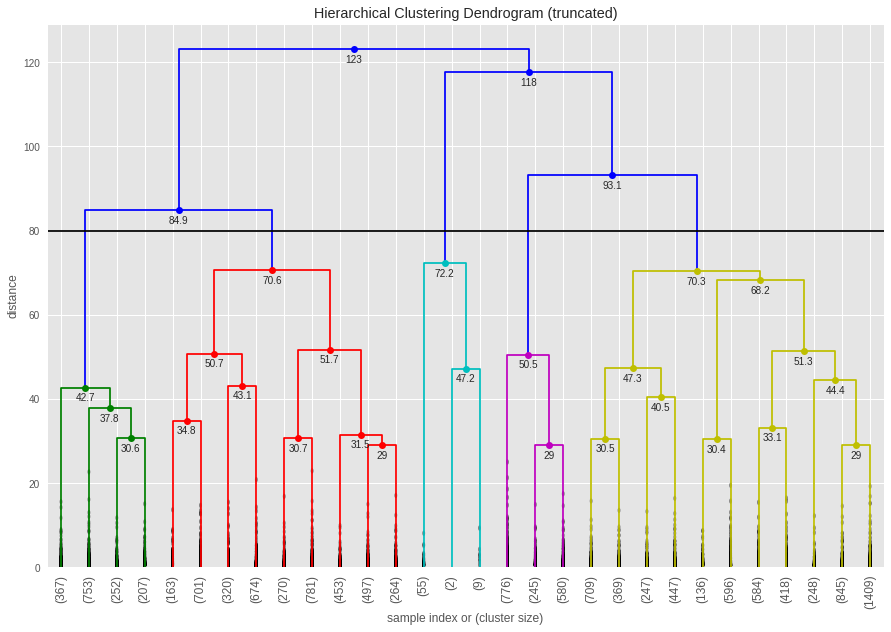

In [9]:
from scipy.cluster.hierarchy import dendrogram, ward

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=80
)

plt.show()

In [10]:
print('distances for the last 5 merges:\n{}'.format(linked_array[-5:,2]))

distances for the last 5 merges:
[  72.18204149   84.87641172   93.14061671  117.67892205  123.02228018]


In [11]:
from scipy.cluster.hierarchy import fcluster
max_d = 80
clusters = fcluster(linked_array, max_d, criterion='distance')
    
labels, counts = np.unique(clusters, return_counts=True)

temp['clusters'] = clusters

print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('rr: {}'.format(round(temp[temp['clusters'] == i].reorder_rate.mean()*100, 2))) 

reorder rates for each cluster


label: 1
n: 1579
rr: 45.17

label: 2
n: 4123
rr: 38.8

label: 3
n: 66
rr: 72.16

label: 4
n: 1601
rr: 49.73

label: 5
n: 6008
rr: 62.12


In [12]:
label = 3
print('reorder rate for cluster {0}: {1}'.format(label, round(temp[temp['clusters'] == label].reorder_rate.mean()*100,2)))
pd.merge(right=temp[temp['clusters'] == label], left=products, left_index=True, right_index=True).head()

reorder rate for cluster 3: 72.16


,product_name,aisle_id,department_id,count,reorder_rate,add_to_cart_mean,order_dow,order_hour_of_day,days_since_prior_order,clusters
4605,Yellow Onions,83,4,3762,0.677299,8.417331,2.587453,13.574163,17.890625,3
4920,Seedless Red Grapes,123,4,4059,0.706824,8.346883,2.631929,13.442474,16.031250,3
5077,100% Whole Wheat Bread,112,3,2298,0.762402,7.596171,2.558747,13.432550,17.484375,3
5450,Small Hass Avocado,24,4,3103,0.705446,7.341283,2.529165,13.659040,16.281250,3
5876,Organic Lemon,24,4,3505,0.716120,8.381455,2.663338,13.605421,16.250000,3


## How does RobustScaler change things?

In [13]:
temp.drop('clusters', axis=1, inplace=True)

from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
temp_robust = robust_scaler.fit_transform(temp)

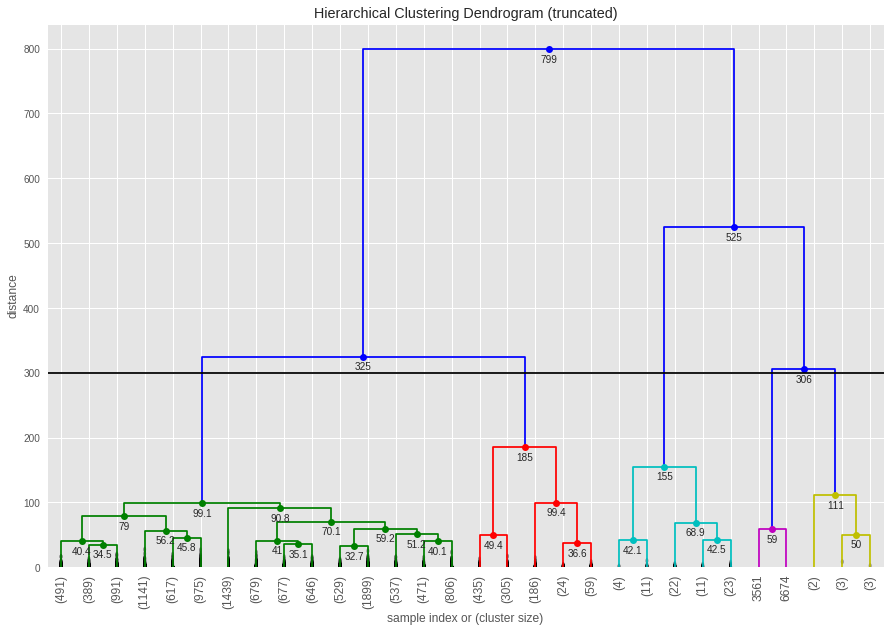

In [14]:
linked_array = ward(temp_robust)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=300
)

plt.show()

In [16]:
from scipy.cluster.hierarchy import fcluster
max_d = 300
clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

temp['clusters'] = clusters

print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('rr: {}'.format(round(temp[temp['clusters'] == i].reorder_rate.mean()*100, 2))) 

reorder rates for each cluster


label: 1
n: 12287
rr: 50.58

label: 2
n: 1009
rr: 61.1

label: 3
n: 71
rr: 69.37

label: 4
n: 2
rr: 87.37

label: 5
n: 8
rr: 77.75


## RobustScaler gave us one bin with many products, which is less informative than StandardScaler.
In case you were curious, cluster 4 contains "Bag of Organic Bananas" and "Banana". Cluster 5 contained produce, all from department 4.

## How would our clusters change if we dropped everything but 'count' and 'reorder_rate'?

In [17]:
temp_scaled = scaler.fit_transform(temp[['count', 'reorder_rate']])
print('done.')

done.


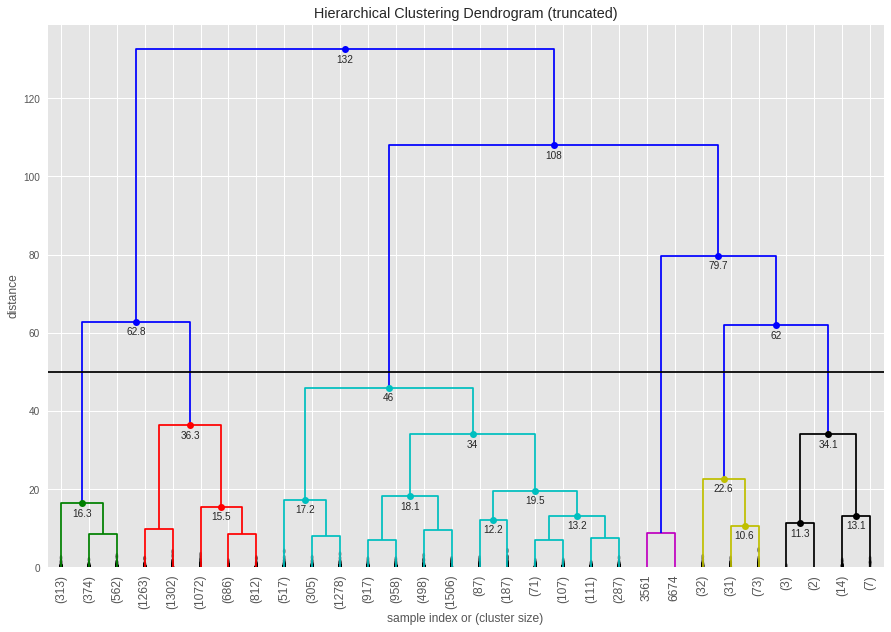

In [18]:
linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=50
)

plt.show()

In [25]:
max_d = 50
clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

temp['clusters'] = clusters

print('reorder rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('rr: {}'.format(round(temp[temp['clusters'] == i].reorder_rate.mean()*100, 2))) 

reorder rates for each cluster


label: 1
n: 1249
rr: 17.08

label: 2
n: 5135
rr: 41.68

label: 3
n: 6829
rr: 64.75

label: 4
n: 2
rr: 87.37

label: 5
n: 136
rr: 68.29

label: 6
n: 26
rr: 73.04


This may be our most informative clustering yet. 
We have six different clusters, each with notably different reorder rates.
There are 1,200+ products that only get reordered 17% of the time.
Another 5,100 products only get reordered 42% of the time.

We could narrow this down to four clusters:

1. Cluster 1 (17%)
2. Cluster 2 (42%)
3. Cluster 3 (65%) and Cluster 5 (68%)
4. Cluster 4 (87%) and Cluster 6 (73%)

Next Steps: Add these different cluster results to a classification algorithm and see how it affects performance.